In [65]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import torch.nn.init as init

import torch.utils.data as Data
import torchvision.datasets as dset
from torchvision import transforms

In [67]:
trans = transforms.Compose([transforms.Grayscale(),transforms.ToTensor()])
train_set = dset.CIFAR10('./cifar10', train=True, transform=trans, download=True)

Files already downloaded and verified


In [0]:
BATCH_SIZE = 80

train_loader = Data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)

In [0]:
class SimpleVAE(nn.Module):
    def __init__(self, embed_dim):
        """
        :param embed_dim: dimension of the hidden space, integer
        """
        super(SimpleVAE, self).__init__()
        self.embed_dim = embed_dim
        
        # encoding
        self.norm = nn.BatchNorm1d(32*32)
        self.enc2med = nn.Linear(32*32, 512)
        self.med2mu_enc = nn.Linear(512, embed_dim)
        self.med2log_var_enc = nn.Linear(512, embed_dim)
        
        # decoding
        self.sample2med = nn.Linear(embed_dim, 512)
        self.med2mu_dec = nn.Linear(512, 32*32)
        self.med2log_var_dec = nn.Linear(512, 32*32)
        
        self.init_weights()
    
    def encode(self, x):
        """
        Retrieves hidden distribution params from the input image
        
        :param x: inputs, Variable of shape (batch_size, 32, 32)
        :return: mean and log_std for the hidden normal distribution, 
        two Variables of shapes (batch_size, embed_dim)
        """
        flattened = x.view(x.size()[0],-1)
        normed_x = self.norm(flattened)
        med = F.relu(self.enc2med(normed_x))
        return self.med2mu_enc(med), self.med2log_var_enc(med)
    
    def decode(self, z):
        """
        Decodes image distribution params from the sampled hidden state
        
        :param z: inputs, Variable of shape (batch_size, embed_dim)
        :return: mean and log_std for the image normal distribution,
        two Variables of shapes (batch_size, 32, 32)
        """
        med = F.relu(self.sample2med(z))
        mu_dec = self.med2mu_dec(med)
        log_var_dec = self.med2log_var_dec(med)
        
        mu_dec = mu_dec.view(mu_dec.size()[0], 32, 32)
        log_var_dec = log_var_dec.view(log_var_dec.size()[0], 32, 32)
        return mu_dec, log_var_dec
    
    def reparametrize(self, mu, log_var):
        """
        Performs reparametrization trick to sample data
        
        :param mu: mean of the desired distribution, Variable of shape (batch_size, embed_dim)
        :param log_var: log_std of the desired distribution, 
        Variable of shape (batch_size, embed_dim)
        :return: samples, Variable of shape (batch_size, embed_dim)
        """
        standard_normal = Normal(torch.zeros(mu.size()[0], self.embed_dim), 
                                      torch.ones(mu.size()[0], self.embed_dim))
        if torch.cuda.is_available():
            r = Variable(standard_normal.sample().cuda(), requires_grad=False)
        else:
            r = Variable(standard_normal.sample(), requires_grad=False)
        
        return r * torch.exp(0.5 * log_var) + mu
    
    def forward(self, x):
        """
        Encodes input to get mean and std of hidden representations,
        and then decodes a sample from them
        
        :param x: inputs, Variable of shape (batch_size, 1, 32, 32)
        :return: post-processed mean and log_std for the image normal distribution,
        two Variables of shapes (batch_size, 32, 32)
        """
        self.mu_enc, self.log_var_enc = self.encode(x)
        
        sample_z = self.reparametrize(self.mu_enc, self.log_var_enc)
        
        self.mu_dec, self.log_var_dec = self.decode(sample_z)
        
        return F.relu(self.mu_dec), F.relu(self.log_var_dec)
    
    def vae_loss(self, prediction, log_dispersion, target, tau):
        """
        Computes reconstruction loss, given prediction and target.
        IMPORTANT! Assumes that the prediction was already fed through the forward
        and self.mu_enc, self.log_var_enc, self.log_var_dec stores relevant values
        
        :param prediction: reconstructed image, Variable of shape (batch_size, 32, 32)
        :param log_dispersion: per-pixel log of dispersion, Variable of shape (batch_size, 32, 32)
        :param target: ground-truth image, Variable of shape (batch_size, 32, 32)
        :param tau: warm-start weight, float Variabe of shape (1,) 
        :return: averaged accross batches loss, float Variable of shape (1,)
        """
        est_x = prediction.view(prediction.size()[0],-1)
        est_log_sigma = log_dispersion.view(log_dispersion.size()[0],-1)
        true_x = target.view(target.size()[0],-1)
        
        l2_loss = 0.5 * torch.sum((est_x - true_x)**2/est_log_sigma.exp(), dim=1)
        
        dec_reg = 0.5 * torch.sum(est_log_sigma, dim=1)
        
        enc_reg = (0.5/1000) * torch.sum(self.mu_enc**2 + self.log_var_enc.exp() - self.log_var_enc, dim=1)
        
        return torch.mean(l2_loss + dec_reg + enc_reg * tau)
    
    def generate(self, z):
        """
        Generates an example
        
        :param z: hidden sample, Variable of shape (embed_dim,)
        :return: generated image, Variable of shape (32, 32)
        """
        return self.decode(z)
    
    def init_weights(self):
        """
        Initialize weights of the model
        """
        relu_gain = init.calculate_gain('relu')
        
        init.xavier_uniform(self.enc2med.weight, relu_gain)
        init.xavier_uniform(self.med2mu_enc.weight)
        init.xavier_uniform(self.med2log_var_enc.weight)
        
        init.xavier_uniform(self.sample2med.weight, relu_gain)
        init.xavier_uniform(self.med2mu_dec.weight)
        init.xavier_uniform(self.med2log_var_dec.weight)

In [70]:
autoencoder = SimpleVAE(16)

optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

if torch.cuda.is_available():
    print('using cuda...')
    autoencoder = autoencoder.cuda()

using cuda...


In [0]:
def dynamic_tau(epoch):
    # warm start condition
    tau = 0
    if epoch < 10:
        tau = 0
    elif epoch < 30:
        tau = (epoch-9)/20
    else:
        tau = 1
    return tau

In [72]:
from tqdm import tqdm

N_EPOCHS = 100

epoch_loss = []
avg_loss = 0

for epoch in tqdm(range(N_EPOCHS)):
    print('-'*10)
    print('EPOCH:', epoch)
    avg_loss = 0
    ctau = dynamic_tau(epoch)
    
    for batch_ix, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        if torch.cuda.is_available():
            var_x, target = Variable(x.cuda()), Variable(target.cuda())
        else:
            var_x, target = Variable(x), Variable(target)
        out = autoencoder(var_x)
        loss = autoencoder.vae_loss(out[0], out[1], var_x, ctau)
        
        avg_loss += loss.data[0]
        loss.backward()
        optimizer.step()
    
    print('EPOCH LOSS:', avg_loss)
    epoch_loss += [avg_loss]

  0%|          | 0/100 [00:00<?, ?it/s]

----------
EPOCH: 0


  1%|          | 1/100 [00:10<16:57, 10.28s/it]

EPOCH LOSS: 7520.054228782654
----------
EPOCH: 1


  2%|▏         | 2/100 [00:20<16:38, 10.19s/it]

EPOCH LOSS: 5316.608006954193
----------
EPOCH: 2


  3%|▎         | 3/100 [00:30<16:25, 10.16s/it]

EPOCH LOSS: 5141.428269863129
----------
EPOCH: 3


  4%|▍         | 4/100 [00:40<16:14, 10.15s/it]

EPOCH LOSS: 5029.606504917145
----------
EPOCH: 4


  5%|▌         | 5/100 [00:50<16:03, 10.15s/it]

EPOCH LOSS: 5006.582355976105
----------
EPOCH: 5


  6%|▌         | 6/100 [01:00<15:52, 10.14s/it]

EPOCH LOSS: 4955.915378570557
----------
EPOCH: 6


  7%|▋         | 7/100 [01:10<15:42, 10.13s/it]

EPOCH LOSS: 4918.917025566101
----------
EPOCH: 7


  8%|▊         | 8/100 [01:21<15:32, 10.13s/it]

EPOCH LOSS: 4896.752794742584
----------
EPOCH: 8


  9%|▉         | 9/100 [01:31<15:21, 10.13s/it]

EPOCH LOSS: 4862.29750919342
----------
EPOCH: 9


 10%|█         | 10/100 [01:41<15:11, 10.13s/it]

EPOCH LOSS: 4832.150199890137
----------
EPOCH: 10


 11%|█         | 11/100 [01:51<15:01, 10.13s/it]

EPOCH LOSS: 4829.240854263306
----------
EPOCH: 11


 12%|█▏        | 12/100 [02:01<14:51, 10.13s/it]

EPOCH LOSS: 4816.641993999481
----------
EPOCH: 12


 13%|█▎        | 13/100 [02:11<14:40, 10.12s/it]

EPOCH LOSS: 4824.041965484619
----------
EPOCH: 13


 14%|█▍        | 14/100 [02:21<14:30, 10.12s/it]

EPOCH LOSS: 4779.226736545563
----------
EPOCH: 14


 15%|█▌        | 15/100 [02:31<14:20, 10.12s/it]

EPOCH LOSS: 4785.335319042206
----------
EPOCH: 15


 16%|█▌        | 16/100 [02:41<14:10, 10.12s/it]

EPOCH LOSS: 4754.954399585724
----------
EPOCH: 16


 17%|█▋        | 17/100 [02:52<13:59, 10.12s/it]

EPOCH LOSS: 4747.424900054932
----------
EPOCH: 17


 18%|█▊        | 18/100 [03:02<13:49, 10.12s/it]

EPOCH LOSS: 4729.873741149902
----------
EPOCH: 18


 19%|█▉        | 19/100 [03:12<13:39, 10.12s/it]

EPOCH LOSS: 4725.190996646881
----------
EPOCH: 19


 20%|██        | 20/100 [03:22<13:29, 10.12s/it]

EPOCH LOSS: 4713.829625606537
----------
EPOCH: 20


 21%|██        | 21/100 [03:32<13:19, 10.12s/it]

EPOCH LOSS: 4716.111834526062
----------
EPOCH: 21


 22%|██▏       | 22/100 [03:42<13:09, 10.12s/it]

EPOCH LOSS: 4709.847551345825
----------
EPOCH: 22


 23%|██▎       | 23/100 [03:52<12:58, 10.12s/it]

EPOCH LOSS: 4705.215372085571
----------
EPOCH: 23


 24%|██▍       | 24/100 [04:02<12:48, 10.12s/it]

EPOCH LOSS: 4705.369721412659
----------
EPOCH: 24


 25%|██▌       | 25/100 [04:12<12:38, 10.12s/it]

EPOCH LOSS: 4693.107315063477
----------
EPOCH: 25


 26%|██▌       | 26/100 [04:22<12:28, 10.11s/it]

EPOCH LOSS: 4700.762793540955
----------
EPOCH: 26


 27%|██▋       | 27/100 [04:33<12:18, 10.11s/it]

EPOCH LOSS: 4682.87038230896
----------
EPOCH: 27


 28%|██▊       | 28/100 [04:43<12:08, 10.11s/it]

EPOCH LOSS: 4687.697241783142
----------
EPOCH: 28


 29%|██▉       | 29/100 [04:53<11:58, 10.11s/it]

EPOCH LOSS: 4679.4950041770935
----------
EPOCH: 29


 30%|███       | 30/100 [05:03<11:47, 10.11s/it]

EPOCH LOSS: 4684.752775192261
----------
EPOCH: 30


 31%|███       | 31/100 [05:13<11:37, 10.11s/it]

EPOCH LOSS: 4666.395822048187
----------
EPOCH: 31


 32%|███▏      | 32/100 [05:23<11:27, 10.11s/it]

EPOCH LOSS: 4666.27911233902
----------
EPOCH: 32


 33%|███▎      | 33/100 [05:33<11:17, 10.11s/it]

EPOCH LOSS: 4662.78538608551
----------
EPOCH: 33


 34%|███▍      | 34/100 [05:43<11:07, 10.11s/it]

EPOCH LOSS: 4650.670513629913
----------
EPOCH: 34


 35%|███▌      | 35/100 [05:53<10:57, 10.11s/it]

EPOCH LOSS: 4663.9013657569885
----------
EPOCH: 35


 36%|███▌      | 36/100 [06:04<10:47, 10.11s/it]

EPOCH LOSS: 4639.201328754425
----------
EPOCH: 36


 37%|███▋      | 37/100 [06:14<10:37, 10.11s/it]

EPOCH LOSS: 4642.385800361633
----------
EPOCH: 37


 38%|███▊      | 38/100 [06:24<10:27, 10.11s/it]

EPOCH LOSS: 4634.274791240692
----------
EPOCH: 38


 39%|███▉      | 39/100 [06:34<10:16, 10.11s/it]

EPOCH LOSS: 4647.339087486267
----------
EPOCH: 39


 40%|████      | 40/100 [06:44<10:06, 10.11s/it]

EPOCH LOSS: 4633.476972579956
----------
EPOCH: 40


 41%|████      | 41/100 [06:54<09:56, 10.11s/it]

EPOCH LOSS: 4635.407016277313
----------
EPOCH: 41


 42%|████▏     | 42/100 [07:04<09:46, 10.11s/it]

EPOCH LOSS: 4642.316515445709
----------
EPOCH: 42


 43%|████▎     | 43/100 [07:14<09:36, 10.11s/it]

EPOCH LOSS: 4643.437894821167
----------
EPOCH: 43


 44%|████▍     | 44/100 [07:24<09:26, 10.11s/it]

EPOCH LOSS: 4625.043781280518
----------
EPOCH: 44


 45%|████▌     | 45/100 [07:35<09:16, 10.11s/it]

EPOCH LOSS: 4625.332372665405
----------
EPOCH: 45


 46%|████▌     | 46/100 [07:45<09:06, 10.11s/it]

EPOCH LOSS: 4633.118984699249
----------
EPOCH: 46


 47%|████▋     | 47/100 [07:55<08:55, 10.11s/it]

EPOCH LOSS: 4617.988094329834
----------
EPOCH: 47


 48%|████▊     | 48/100 [08:05<08:45, 10.11s/it]

EPOCH LOSS: 4609.01941204071
----------
EPOCH: 48


 49%|████▉     | 49/100 [08:15<08:35, 10.11s/it]

EPOCH LOSS: 4610.963903903961
----------
EPOCH: 49


 50%|█████     | 50/100 [08:25<08:25, 10.11s/it]

EPOCH LOSS: 4624.973724365234
----------
EPOCH: 50


 51%|█████     | 51/100 [08:35<08:15, 10.11s/it]

EPOCH LOSS: 4605.641260623932
----------
EPOCH: 51


 52%|█████▏    | 52/100 [08:45<08:05, 10.11s/it]

EPOCH LOSS: 4615.232356071472
----------
EPOCH: 52


 53%|█████▎    | 53/100 [08:55<07:55, 10.11s/it]

EPOCH LOSS: 4615.392421722412
----------
EPOCH: 53


 54%|█████▍    | 54/100 [09:05<07:45, 10.11s/it]

EPOCH LOSS: 4611.299495220184
----------
EPOCH: 54


 55%|█████▌    | 55/100 [09:16<07:34, 10.11s/it]

EPOCH LOSS: 4598.999173641205
----------
EPOCH: 55


 56%|█████▌    | 56/100 [09:26<07:24, 10.11s/it]

EPOCH LOSS: 4591.0587911605835
----------
EPOCH: 56


 57%|█████▋    | 57/100 [09:36<07:14, 10.11s/it]

EPOCH LOSS: 4588.2726521492
----------
EPOCH: 57


 58%|█████▊    | 58/100 [09:46<07:04, 10.11s/it]

EPOCH LOSS: 4591.236759185791
----------
EPOCH: 58


 59%|█████▉    | 59/100 [09:56<06:54, 10.11s/it]

EPOCH LOSS: 4597.132759571075
----------
EPOCH: 59


 60%|██████    | 60/100 [10:06<06:44, 10.11s/it]

EPOCH LOSS: 4593.2732520103455
----------
EPOCH: 60


 61%|██████    | 61/100 [10:16<06:34, 10.11s/it]

EPOCH LOSS: 4593.920786857605
----------
EPOCH: 61


 62%|██████▏   | 62/100 [10:26<06:24, 10.11s/it]

EPOCH LOSS: 4589.51887845993
----------
EPOCH: 62


 63%|██████▎   | 63/100 [10:36<06:14, 10.11s/it]

EPOCH LOSS: 4588.116080760956
----------
EPOCH: 63


 64%|██████▍   | 64/100 [10:47<06:03, 10.11s/it]

EPOCH LOSS: 4602.450571537018
----------
EPOCH: 64


 65%|██████▌   | 65/100 [10:57<05:53, 10.11s/it]

EPOCH LOSS: 4582.5691447258
----------
EPOCH: 65


 66%|██████▌   | 66/100 [11:07<05:43, 10.11s/it]

EPOCH LOSS: 4593.947777748108
----------
EPOCH: 66


 67%|██████▋   | 67/100 [11:17<05:33, 10.11s/it]

EPOCH LOSS: 4569.892430305481
----------
EPOCH: 67


 68%|██████▊   | 68/100 [11:27<05:23, 10.11s/it]

EPOCH LOSS: 4577.333742141724
----------
EPOCH: 68


 69%|██████▉   | 69/100 [11:37<05:13, 10.11s/it]

EPOCH LOSS: 4586.950151920319
----------
EPOCH: 69


 70%|███████   | 70/100 [11:47<05:03, 10.11s/it]

EPOCH LOSS: 4578.399658203125
----------
EPOCH: 70


 71%|███████   | 71/100 [11:57<04:53, 10.11s/it]

EPOCH LOSS: 4589.075718402863
----------
EPOCH: 71


 72%|███████▏  | 72/100 [12:07<04:43, 10.11s/it]

EPOCH LOSS: 4580.704184055328
----------
EPOCH: 72


 73%|███████▎  | 73/100 [12:17<04:32, 10.11s/it]

EPOCH LOSS: 4572.404256343842
----------
EPOCH: 73


 74%|███████▍  | 74/100 [12:28<04:22, 10.11s/it]

EPOCH LOSS: 4585.422970294952
----------
EPOCH: 74


 75%|███████▌  | 75/100 [12:38<04:12, 10.11s/it]

EPOCH LOSS: 4574.046590328217
----------
EPOCH: 75


 76%|███████▌  | 76/100 [12:48<04:02, 10.11s/it]

EPOCH LOSS: 4573.679106235504
----------
EPOCH: 76


 77%|███████▋  | 77/100 [12:58<03:52, 10.11s/it]

EPOCH LOSS: 4565.136312007904
----------
EPOCH: 77


 78%|███████▊  | 78/100 [13:08<03:42, 10.11s/it]

EPOCH LOSS: 4573.842130184174
----------
EPOCH: 78


 79%|███████▉  | 79/100 [13:18<03:32, 10.11s/it]

EPOCH LOSS: 4555.929887771606
----------
EPOCH: 79


 80%|████████  | 80/100 [13:28<03:22, 10.11s/it]

EPOCH LOSS: 4570.019170284271
----------
EPOCH: 80


 81%|████████  | 81/100 [13:38<03:12, 10.11s/it]

EPOCH LOSS: 4570.38868522644
----------
EPOCH: 81


 82%|████████▏ | 82/100 [13:48<03:01, 10.11s/it]

EPOCH LOSS: 4574.880425453186
----------
EPOCH: 82


 83%|████████▎ | 83/100 [13:58<02:51, 10.11s/it]

EPOCH LOSS: 4572.010356426239
----------
EPOCH: 83


 84%|████████▍ | 84/100 [14:09<02:41, 10.11s/it]

EPOCH LOSS: 4550.044077396393
----------
EPOCH: 84


 85%|████████▌ | 85/100 [14:19<02:31, 10.11s/it]

EPOCH LOSS: 4575.675719261169
----------
EPOCH: 85


 86%|████████▌ | 86/100 [14:29<02:21, 10.11s/it]

EPOCH LOSS: 4570.11088848114
----------
EPOCH: 86


 87%|████████▋ | 87/100 [14:39<02:11, 10.11s/it]

EPOCH LOSS: 4561.441467761993
----------
EPOCH: 87


 88%|████████▊ | 88/100 [14:49<02:01, 10.11s/it]

EPOCH LOSS: 4550.4508719444275
----------
EPOCH: 88


 89%|████████▉ | 89/100 [14:59<01:51, 10.11s/it]

EPOCH LOSS: 4555.738861083984
----------
EPOCH: 89


 90%|█████████ | 90/100 [15:09<01:41, 10.11s/it]

EPOCH LOSS: 4573.563570022583
----------
EPOCH: 90


 91%|█████████ | 91/100 [15:19<01:30, 10.11s/it]

EPOCH LOSS: 4557.360863685608
----------
EPOCH: 91


 92%|█████████▏| 92/100 [15:29<01:20, 10.11s/it]

EPOCH LOSS: 4553.296642303467
----------
EPOCH: 92


 93%|█████████▎| 93/100 [15:39<01:10, 10.11s/it]

EPOCH LOSS: 4565.515442371368
----------
EPOCH: 93


 94%|█████████▍| 94/100 [15:49<01:00, 10.11s/it]

EPOCH LOSS: 4560.983346939087
----------
EPOCH: 94


 95%|█████████▌| 95/100 [16:00<00:50, 10.11s/it]

EPOCH LOSS: 4550.966053009033
----------
EPOCH: 95


 96%|█████████▌| 96/100 [16:10<00:40, 10.11s/it]

EPOCH LOSS: 4554.184484958649
----------
EPOCH: 96


 97%|█████████▋| 97/100 [16:20<00:30, 10.11s/it]

EPOCH LOSS: 4542.06617307663
----------
EPOCH: 97


 98%|█████████▊| 98/100 [16:30<00:20, 10.11s/it]

EPOCH LOSS: 4549.084393501282
----------
EPOCH: 98


 99%|█████████▉| 99/100 [16:40<00:10, 10.11s/it]

EPOCH LOSS: 4560.317217350006
----------
EPOCH: 99


100%|██████████| 100/100 [16:50<00:00, 10.11s/it]

EPOCH LOSS: 4550.817540645599


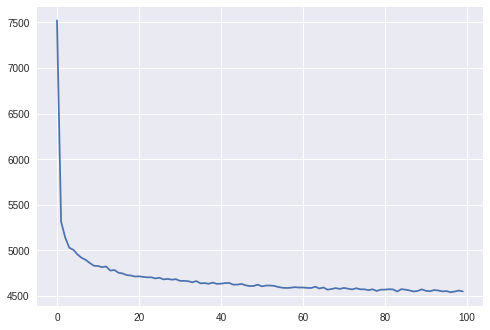

In [73]:
plt.plot(epoch_loss)
plt.show()

In [0]:
def get_example():
  
  for batch_ix, (x, target) in enumerate(train_loader):
    if batch_ix == 1:
      break
    
    var_x, target = Variable(x.cuda()), Variable(target.cuda())
    
    out = autoencoder(var_x)
    
    ex_mu, ex_log_var = autoencoder.encode(var_x)
    
    loss = autoencoder.vae_loss(out[0], out[1], var_x, 1)
    
    ex_out = out[0].data[0,:,:].cpu().numpy()
    ex_x = var_x.data[0,0,:,:].cpu().numpy()
    ex_target = target.data[0]
    ex_mu = ex_mu[0,:].data.cpu().numpy()
    ex_log_var = ex_log_var[0,:].data.cpu().numpy()
    print('ex full loss:', loss.data[0])
    print('ex l2 loss:', np.linalg.norm(ex_x - ex_out))
    print('ex mu mean:', np.mean(ex_mu))
    print('ex log var mean:', np.mean(ex_log_var))
  return ex_x, ex_out, ex_target

label_names = ['airplane', 'automobile', 'bird', 
               'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def show_example():
  ex_x, ex_out, ex_target = get_example()
  fig = plt.figure(figsize=(8,16))
  ax = fig.add_subplot(121)
  ax.set_title('ORIGINAL, CLASS - '+label_names[ex_target])
  plt.imshow(ex_x, cmap='gray')
  ax2 = fig.add_subplot(122)
  ax2.set_title('RECONSTRUCTED')
  plt.imshow(ex_out, cmap='gray')
  plt.show()

ex full loss: 6.915203094482422
ex l2 loss: 3.6669173
ex mu mean: 0.07615973
ex log var mean: -8.762808


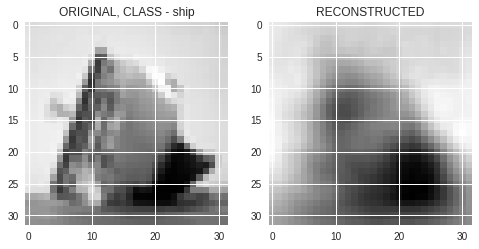

In [75]:
show_example()

ex full loss: 7.192509651184082
ex l2 loss: 2.0980551
ex mu mean: -0.014517078
ex log var mean: -9.134165


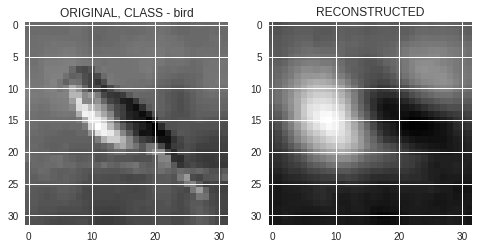

In [76]:
show_example()

ex full loss: 6.465724945068359
ex l2 loss: 3.756923
ex mu mean: -0.135573
ex log var mean: -9.962357


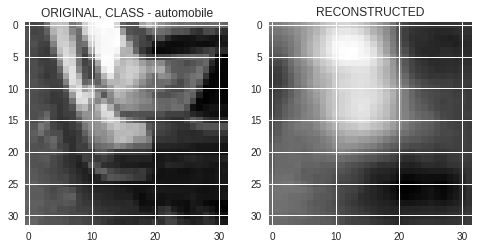

In [77]:
show_example()

In [0]:
def generate_example(mu, log_var):
  ex_mu = torch.FloatTensor(np.ones((1,16))*mu)
  ex_log_var = torch.FloatTensor(np.ones((1,16))*log_var)
  
  ex_z = autoencoder.reparametrize(Variable(ex_mu.cuda()), Variable(ex_log_var.cuda()))
  gen_ex, _ = autoencoder.generate(ex_z)
  generated_ex = gen_ex[0,:].data.cpu().numpy()
  plt.title('Generated')
  plt.imshow(generated_ex, cmap='gray')
  plt.show()

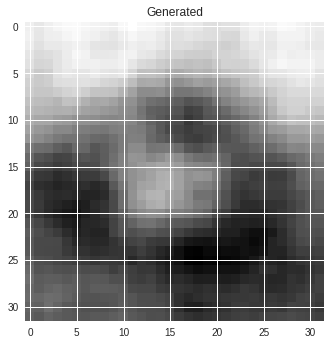

In [90]:
generate_example(0.01, -8.0)

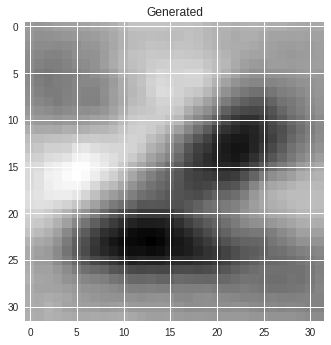

In [99]:
generate_example(-0.1, -9.0)

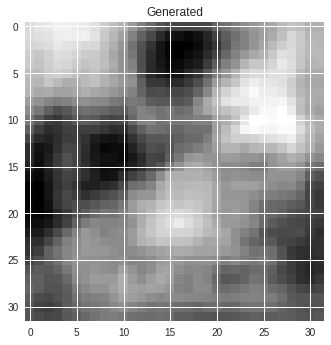

In [121]:
generate_example(0.6, -8)

In [122]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
torch.save(autoencoder.state_dict(), 'drive/vae_checkpoint.ptr')